# Extract

In [1]:
import gzip             #importo la librería para leer los archivos gzip, formato de compresion en el que vinieron los archivos
import pandas as pd     #importo librería pandas que vamos a usar para el data frame
import ast              #importo librería ast que me ayuda a leer la gramatica abstracta

### Steamgames

In [2]:
#si bien se podría descomprimir el archivo y directamente leerlo de pandas, dado que futuras actualziaciones pueden venir como gzip, es preferible trabajarlos desde ese formato
with gzip.open('Datos_sin_procesar/steam_games.json.gz', 'rb') as f:
    df_steamgames=pd.read_json(f, lines=True)

### User Items

In [3]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/users_items.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_users_items = pd.DataFrame(data)

### User Reviews

In [4]:
#comienzo con una lista para poder insertar cada línea del archivo
data=[]
with gzip.open('Datos_sin_procesar/user_reviews.json.gz', 'rb') as f:
    for line in f:
        #cargar la información usando ast, porque si se usa json se dan errores por sintacis de gramatica en el uso de comillas
        data.append(ast.literal_eval(line.decode('utf-8')))

# Convierto la lista a DataFrame
df_user_reviews = pd.DataFrame(data)

# Transorm

### Steamgames

In [5]:
#Tratamiento de Nulos

#se eliminan los valores con todos nulos
df_steamgames.dropna(inplace= True, how='all')

#se verifica si existe algún id que esté nulo mediante df_steamgames[df_steamgames['id'].isnull()] y se concluye que sí
#se verifica sin con la url podemos obetener el id del juego, mediante el par df_steamgames[['url','id']], 
#y se concluye que sí, y se pasa a asignar ese valor a los faltantes

#Llenado de Ids nulos

#se importa la libreria re para poder trabajar sobre la extracción del ID de la url, y se genera una función para este propósito
import re

def extraer_numero_url(url):
    if url is None:
        return None
    else:
        match = re.search(r'(\d+)', url)
        if match:
            return match.group(1)
        else:
            return None

#aplicamos la funcion a una columna auxiliar
df_steamgames['id_aux']=df_steamgames['url'].apply(extraer_numero_url)
#aplicamos la columna auxiliar a los valores nulos
df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
#eliminamos los id nulos
df_steamgames.dropna(subset=['id'], inplace=True)
#eliminamos la columna auxiliar
df_steamgames.drop(columns=['id_aux'], inplace=True)

#Se llena el title nulo con el app_name
df_steamgames.loc[df_steamgames['title'].isnull(), 'title'] = df_steamgames['app_name']

#Se llena la columna tags nula con la columna genres. Esto se utiliza luego en el algotirmo de ML
df_steamgames.loc[df_steamgames['tags'].isnull(), 'tags'] = df_steamgames['genres']

C:\Users\feder\AppData\Local\Temp\ipykernel_3852\2436408977.py:28: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_steamgames['id'][df_steamgames['id'].isnull()]=df_steamgames['id_aux']
C:\Users\feder\AppData\Local\Temp\ipykernel_3852\24364

In [6]:
#Tratamiento de Duplicados
#se eliimnan los registros con Id duplicado
df_steamgames.drop_duplicates(subset='id', inplace=True)

In [7]:
#se cambian los nombres de columas que se usan más adelante
df_steamgames = df_steamgames.rename(columns={'id': 'item_id'})
df_steamgames = df_steamgames.rename(columns={'title': 'item_title'})
#se cambia el formato de la columna itemid a entero
df_steamgames['item_id']=df_steamgames['item_id'].astype(int)
#se genera un diccionario de Id y nombre de la app, para su uso posterior (se procesa siempre por Id, pero a la hora de mostrar los datos se muestra el nombre)
titlexid=dict(zip(df_steamgames['item_id'],df_steamgames['item_title']))


La columna genres tiene listas con los generos a los que puede pertenecer el juego. Para un mejor procesamiento a posteriori de los datos, se transforma esa columna en varias columnas dummies con cada uno de esos valores.
También se tiene la columna tags, pero que tiene muchos más valores. Algunos de ellos son las categorías, y también otros tipos de etiquetas. Se arma un dataframe para rellenar los valores faltantes de etiquetas.

In [8]:
# primero se llenan los nulos con valor [], para su posterior procesamiento
# Se define una función para reemplazar los valores nulos con una lista vacía
def reemplazonulo(lst):
    return lst if isinstance(lst, list) else []
# Aplica la función a la columna con listas
df_steamgames['genres'] = df_steamgames['genres'].apply(reemplazonulo)
df_steamgames['tags'] = df_steamgames['tags'].apply(reemplazonulo)

#Se separa la columna de generos en un dataframe
df_genres = df_steamgames['genres'].apply(lambda x: pd.Series({val: 1 for val in x}))
#lleno los nulos con 0
df_genres.fillna(0, inplace=True)
#Se renombran columnas que tienen mal los nombres
df_genres.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)

#Se genera el dataframe de de tags
df_tags = df_steamgames['tags'].apply(lambda x: pd.Series({val: 1 for val in x}))
df_tags.fillna(0, inplace=True)
#idem caso anterior con nombres mal importados
df_tags.rename(columns={'Design &amp; Illustration':'Design & Illustration','Animation &amp; Modeling':'Animation & Modeling'}, inplace= True)

#generamos un dataframe que usaremos luego en el algoritmo de ML
df_tags_for_ML = pd.concat([df_steamgames[['item_id', 'item_title']], df_tags], axis=1)
#cambiamos de formato sus columnas para que ocupen menos espacio
columnas=df_tags_for_ML.columns.tolist()
columnas.remove('item_title')
for i in columnas:
    df_tags_for_ML[i]= df_tags_for_ML[i].astype(int)
#se cambia el indice al id
df_tags_for_ML.set_index('item_id', inplace=True)
#se exporta el dataframe, y se elimina
df_tags_for_ML.to_csv('Datos_procesados/df_tags_for_ML.csv')
#se elimina para que no ocupe más espacio
del df_tags_for_ML

genres=df_genres.columns.tolist()
#se completan las categorías que son nulas en la columna de categoria pero si fueron etiquetadas usando los tags
for i in genres:
    for index, row in df_genres.iterrows():
        if row[i] == 0:
            df_genres.at[index, i] = df_tags.at[index, i]
df_steamgames=pd.concat([df_steamgames,df_genres], axis=1)

#se cambia el formato de las columnas para ocupar menos espacio en memoria
for i in genres:
    df_steamgames[i] = df_steamgames[i].fillna(0)
    df_steamgames[i] = df_steamgames[i].astype(int)

#se eliminan los dataframes que ya no usamos
del df_genres
del df_tags

In [9]:
#Año de lanzamiento

#Se inserta el año de lanzamiento
df_steamgames['release_date'] = pd.to_datetime(df_steamgames['release_date'], errors='coerce')
df_steamgames.loc[~df_steamgames['release_date'].notnull(), 'release_date'] = None
df_steamgames['release_year'] = df_steamgames['release_date'].dt.year

#se cambia el tipos de datos para ocupar menos espacio
df_steamgames['release_year'] = df_steamgames['release_year'].fillna(0)
df_steamgames['release_year'] = df_steamgames['release_year'].astype(int)

#Se genera un diccionario con el año de lanzamiento de cada Id (se usa a posteriori)
releaseyearxid=dict(zip(df_steamgames['item_id'],df_steamgames['release_year']))

In [10]:
#Precio: cambiamos los valores de texto por 0
df_steamgames['price'] = pd.to_numeric(df_steamgames['price'], errors='coerce').fillna(0)

In [11]:
#se eliminan las columnas que no sirven
df_steamgames.drop(['publisher','app_name','genres', 'tags' ,'url','release_date','reviews_url','specs','early_access',
                                 'developer'],axis=1,inplace=True)

### User Items

Se posee en la columna items listas con diccionarios. Cada diccionario tiene 4 atributos. Se genera una fila para cada diccionario, y 4 columnas posteriores a partir del diccionario

In [12]:
#primero se inserta una fila por cada diccionario de la columna item
df_users_items=df_users_items.explode('items')
df_users_items = df_users_items.reset_index(drop=True)

In [13]:
#luego se arma un dataframe nuevo a partir de los diccionarios de item, con una columna por cada atributo
# el metodo normal sería este, pero tarda mucho, con lo cual buscamos extraer columna por columna df_users_items_items=df_users_items['items'].apply(pd.Series)

def obtener_elemento(diccionario, clave_busqueda):
    if isinstance(diccionario, dict):
        return diccionario.get(clave_busqueda)
    else:
        return diccionario

df_users_items['item_id'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_id'))
df_users_items['item_name'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'item_name'))
df_users_items['playtime_forever'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_forever'))
df_users_items['playtime_2weeks'] = df_users_items['items'].apply(lambda x: obtener_elemento(x, 'playtime_2weeks'))

In [14]:
#Saco las columnas items que ya no no utiles
df_users_items.drop(['steam_id','user_url','items', 'items_count'], axis=1,inplace= True)
#eliminamos las filas que no tienen valor de juego
df_users_items = df_users_items.dropna(subset=['item_id', 'item_name'], how='all')

### User Reviews

Cada objeto de la columna review es una lista que tiene varios valores de diccionario, de 7 atributos 'funny', 'posted',   'last_edited', 'item_id', 'helpful', 'recommend', 'review'. Se debe transformar cada diccionario en una fila, y cada uno de estos 7 atriburos en una columna, de manera tal que el dataframe refleje la realidad de datos que tenemos

In [15]:
#paso cada lista a una fila, aplicando metodo explode
df_user_reviews=df_user_reviews.explode('reviews')
#paso cada atributo del diccionario a una columna nueva, aplicando metodo apply
df_user_reviews_exp=df_user_reviews['reviews'].apply(pd.Series)
df_user_reviews.reset_index()

,index,user_id,user_url,reviews
0,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20..."
1,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011...."
2,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011..."
3,1,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014...."
4,1,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2..."
...,...,...,...,...
59328,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 10.', 'la..."
59329,25797,76561198312638244,http://steamcommunity.com/profiles/76561198312...,"{'funny': '', 'posted': 'Posted July 8.', 'las..."
59330,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '1 person found this review funny', ..."
59331,25798,LydiaMorley,http://steamcommunity.com/id/LydiaMorley,"{'funny': '', 'posted': 'Posted July 20.', 'la..."


In [16]:
#junto el dataframe original y las nuevas columnas
df_user_reviews=pd.concat([df_user_reviews, df_user_reviews_exp], axis=1)
#elimino la columna original
df_user_reviews.drop(['reviews','user_url', 'funny', 'last_edited', 
                      'helpful', 0], axis=1, inplace=True)

In [17]:
from textblob import TextBlob
df_user_reviews['review'] = df_user_reviews['review'].astype(str)
df_user_reviews['polarity'] = df_user_reviews['review'].apply(lambda text: TextBlob(text).sentiment.polarity)


(array([1.9600e+02, 1.3000e+01, 0.0000e+00, 0.0000e+00, 5.0000e+00,
        9.0000e+00, 9.0000e+00, 3.0000e+00, 1.0000e+00, 1.0000e+00,
        9.4000e+01, 4.0000e+00, 7.0000e+01, 4.0000e+00, 2.6000e+01,
        1.6700e+02, 1.3000e+01, 2.0000e+01, 5.1000e+01, 4.7000e+01,
        8.3000e+01, 2.4000e+01, 7.8000e+01, 2.6000e+01, 3.7000e+01,
        3.4000e+02, 3.0000e+01, 9.2000e+01, 6.4000e+01, 6.5000e+01,
        1.7440e+03, 1.1900e+02, 1.7200e+02, 1.4100e+02, 2.9300e+02,
        1.4900e+02, 1.9900e+02, 3.0900e+02, 2.4000e+02, 8.0400e+02,
        2.5500e+02, 3.8300e+02, 5.5200e+02, 6.2700e+02, 8.5200e+02,
        5.6100e+02, 8.2200e+02, 1.0020e+03, 1.0370e+03, 9.1300e+02,
        1.4095e+04, 1.2080e+03, 1.7440e+03, 1.4290e+03, 2.0370e+03,
        1.2460e+03, 1.4540e+03, 1.9410e+03, 1.4050e+03, 9.8100e+02,
        2.2860e+03, 1.0500e+03, 1.3440e+03, 9.2800e+02, 2.4650e+03,
        5.7000e+02, 6.7200e+02, 7.0000e+02, 6.3500e+02, 8.4000e+02,
        2.6600e+02, 3.6100e+02, 2.6700e+02, 3.61

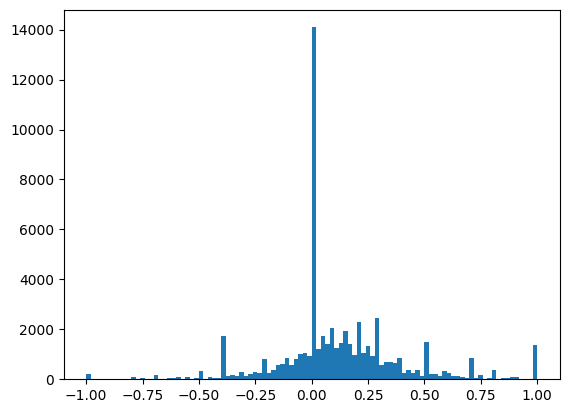

In [18]:
import matplotlib.pyplot as plt
plt.hist(df_user_reviews['polarity'], bins=100)

In [19]:
df_user_reviews['sentiment_analysis'] = df_user_reviews['polarity'].apply(lambda x: 0 if x < 0 else (1 if x == 0 else 2))
df_user_reviews.drop(['review','polarity'], axis=1, inplace=True)

In [20]:
#sacar el año de la review
df_user_reviews['date'] = df_user_reviews['posted'].str.extract(r'(\w+\s\d+(?:,\s\d{4})?)')
df_user_reviews['date'] = pd.to_datetime(df_user_reviews['date'], format='%B %d, %Y', errors='coerce')
df_user_reviews['year'] = df_user_reviews['date'].dt.year
# Convertir los NaN a 0 en la columna 'year'
df_user_reviews['year'] = df_user_reviews['year'].fillna(0)
# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

In [21]:
#dado que el ultimo año de las reseñas que tienen fecha es el 2015, parece que fueron realizadas en el año 2016,
# y cuando se realizaban en ese año no se ponía la fecha. Por eso relleno el valor de los años de reseña faltante 
# con el mayor entre ese año, y el año en que se lanzó el juego
df_steamgames.reset_index()

# Definir una función personalizada para aplicar la lógica deseada
def fill_year(row):
    if row['year'] == 0:
        # Obtener las filas de df_steamgames que cumplen con la condición
        steamgame_rows = df_steamgames[df_steamgames['item_id'] == row['item_id']]
        
        if not steamgame_rows.empty:
            # Si se encontraron filas, obtener el año de la primera fila y verificar si es mayor a 2016
            release_year = steamgame_rows['release_year'].iloc[0]
            return max(release_year, 2016)
        else:
            # Si no se encontraron filas, retornar 2016
            return 2016
    else:
        return row['year']

# Aplicar la función personalizada a la columna 'year' utilizando apply
df_user_reviews['year'] = df_user_reviews.apply(fill_year, axis=1)

# Convertir la columna 'year' a tipo entero
df_user_reviews['year'] = df_user_reviews['year'].astype(int)

In [22]:
#Agrupo lo que me sirve
df_user_item_played_year = df_user_reviews.groupby(['item_id', 'user_id', 'year']).size().reset_index(name='count')
df_user_item_played_year.drop('count', axis=1, inplace=True)
df_user_item_played_year['item_id']=df_user_item_played_year['item_id'].astype(int)

In [23]:
#reseteo el indice
df_user_reviews.reset_index(inplace=True)
df_user_reviews.drop('index', axis=1, inplace=True)

In [24]:
#cambio los tipos de formato que necesito
df_user_reviews['item_id'].fillna(0, inplace=True)
df_user_reviews['item_id']=df_user_reviews['item_id'].astype(int)


C:\Users\feder\AppData\Local\Temp\ipykernel_3852\3494487820.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_user_reviews['item_id'].fillna(0, inplace=True)


In [25]:
df_user_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             59333 non-null  object        
 1   posted              59305 non-null  object        
 2   item_id             59333 non-null  int32         
 3   recommend           59305 non-null  object        
 4   sentiment_analysis  59333 non-null  int64         
 5   date                49186 non-null  datetime64[ns]
 6   year                59333 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 2.7+ MB


In [26]:
#se generan dos dataframes para su posterior uso, uno para usuarios y otro para juegos, para su uso en el EDA
#agrupado por juego
df_reviews_by_game=df_user_reviews.groupby('item_id').agg({
    'recommend': 'mean',
    'sentiment_analysis': 'mean',
    'user_id': 'count'
}).reset_index()
df_reviews_by_game.columns = ['item_id', 'mean_recommend', 'mean_sentiment_analysis', 'total_reviews']
df_reviews_by_game.set_index('item_id')

#agrupado por jugador
df_reviews_by_player=df_user_reviews.groupby('user_id').agg({
    'recommend': 'mean',
    'sentiment_analysis': 'mean',
    'item_id': 'count'
}).reset_index()
df_reviews_by_player.columns = ['user_id', 'mean_recommend', 'mean_sentiment_analysis', 'total_reviews']

# Tranformation for EDA and functions

In [27]:
#Se agregan las horas totales de cada juego
#primero se arma un dataframe que es la suma total de horas jugadas de cada juego
df_hoursxgame = df_users_items.groupby(by=['item_id', 'item_name'])['playtime_forever'].sum().reset_index()
#se cambia el tipo de item_id a integer
df_hoursxgame['item_id']=df_hoursxgame['item_id'].astype(int)
#se agregan las horas al dataframe de steamgames
df_steamgames = df_steamgames.merge(df_hoursxgame[['item_id', 'playtime_forever']], on='item_id', how='left')

In [28]:
#Se agregan los generos de cada juego al df_user_items
#cambio el tipo de valor de item id
df_users_items['item_id']=df_users_items['item_id'].astype(int)
#Incluyo los generos en el dataframe de los usuarios
df_users_items = df_users_items.merge(df_steamgames, on='item_id', how='left')
#cambio nomnbre y elimino columnas duplicadas
df_users_items.rename(columns={'playtime_forever_x':'playtime_forever'}, inplace=True)
df_users_items.drop('playtime_forever_y', axis=1, inplace=True)
#convierto a enteros las columnas de generos para que ocupe menos memoria
for i in genres:
    df_users_items[i] = df_users_items[i].fillna(0).astype(int)

In [29]:
#se incluye el año en el que cada jugador jugó al juego en una columna de users_items
df_users_items=df_users_items.merge(df_user_item_played_year, on=['item_id','user_id'],how='left')

In [30]:
#se suma al dataframe de user_reviews el año de lanzamiento del juego.
df_user_reviews['release_year']=df_user_reviews['item_id'].map(pd.Series(releaseyearxid))
#se cambia el formato de release year
df_user_reviews['release_year'].fillna(0, inplace=True)
df_user_reviews['release_year']=df_user_reviews['release_year'].astype(int)

C:\Users\feder\AppData\Local\Temp\ipykernel_3852\2466913048.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_user_reviews['release_year'].fillna(0, inplace=True)


# Tranformation for functions

#### df_genres_detail

In [31]:
#genero una lista, que luego paso a dataframe, en la que busco el año con el maximo de horas jugadas
genres_RY_list=[]
#voy iterando por cada género
for i in genres:
    # genero un dataframe con cada año de lanzamiento y las horas jugadas, un agrupado del dataframe steamgames
    df_append = df_steamgames[df_steamgames[i] == 1].groupby(by=['release_year'])['playtime_forever'].sum().reset_index()
    # Encuentro el año con la máxima cantidad de horas jugadas
    max_hours_year = df_append.loc[df_append['playtime_forever'].idxmax(), 'release_year']
    # Agrego los datos a la lista de géneros y años de máximas horas jugadas
    genres_RY_list.append({'Genre': i, 'RYMaxHours': max_hours_year})
df_genres=pd.DataFrame(genres_RY_list)
df_genres['Genre']=df_genres['Genre'].astype(str)

In [32]:
## JUGADOR QUE MAS HORAS JUGO

#genero una lista, que luego paso a dataframe, en la que busco el jugador con el maximo de horas jugadas
genres_MaxPlayer_list=[]
#voy iterando por cada género
for index, row in df_genres.iterrows():
    genero = row['Genre']
    # genero un dataframe con cada jugador y las horas jugadas de ese genero, un agrupado del dataframe df_users_items
    df_append = df_users_items[df_users_items[genero] == 1].groupby(by=['user_id'])['playtime_forever'].sum().reset_index()
    if not df_append.empty:
        # Encontrar el jugador con la máxima cantidad de horas jugadas
        max_hours_player = df_append.loc[df_append['playtime_forever'].idxmax(), 'user_id']
    else:
    # Manejar el caso en que la Serie esté vacía
        max_hours_player= 'Player Not Found'
    df_genres.at[index, 'PlayerMH'] = max_hours_player


In [33]:
## AÑO JUGADOR POR CADA JUGADOR

# Itero sobre las filas de df_genresplayer
for index, row in df_genres.iterrows():
    genero = row['Genre']
    jugador = row['PlayerMH']
    
    # Filtro df_users_items para obtener las horas jugadas del jugador por género y año
    df_append_player = df_users_items[(df_users_items[genero] == 1) & (df_users_items['user_id'] == jugador)].groupby(by=['year'])['playtime_forever'].sum().reset_index()
    df_append_player = df_append_player.sort_values(by='playtime_forever', ascending=False)
    
    # Obtengo los años jugados y horas jugadas
    years_by_player = []
    for j in range(min(3, len(df_append_player))):
        this_year = '{Año: ' + str(int(df_append_player['year'].iloc[j])) + ', Horas: ' + str(int(df_append_player['playtime_forever'].iloc[j])) + '}'
        years_by_player.append(this_year)
    years_by_player=str(years_by_player)

    # Asigno la lista de años jugados y horas jugadas a la columna 'Years Played' en la fila actual
    df_genres.at[index, 'Years Played by player'] = years_by_player
    

In [34]:
#se cambia el indice
df_genres.set_index('Genre', inplace=True)
#se exporta el dataframe
df_genres.to_csv('Datos_procesados/genres_analysis.csv')

#### df_year_recommendations

In [35]:
#se genera el dataframe que se va a exportar
df_year_recommendations=pd.DataFrame(df_user_reviews['year'].unique())
#se cambia el nombre de la columna
df_year_recommendations.rename(columns={0:'year'}, inplace=True)
#se generan las columnas para las recomendaciones y no recomendaciones
df_year_recommendations['recommend_id_1']=0
df_year_recommendations['recommend_id_2']=0
df_year_recommendations['recommend_id_3']=0
df_year_recommendations['not_recommend_id_1']=0
df_year_recommendations['not_recommend_id_2']=0
df_year_recommendations['not_recommend_id_3']=0

In [36]:
# Para los recomendados
#Filtro el dataframe
df_user_reviews_recommend = df_user_reviews[(df_user_reviews['recommend'] == True) & (df_user_reviews['sentiment_analysis'] >= 1)]
#saco columnas que no sirven
df_user_reviews_recommend.drop(['user_id', 'posted', 'recommend', 'date'], axis=1, inplace=True)
# Agrupo por item_id y year, y el promedio de recommend
df_grouped_recommend = df_user_reviews_recommend.groupby(['item_id', 'year']).mean().reset_index()
# Para los no recomendados
# Filtro el dataframe
df_user_reviews_not_recommend = df_user_reviews[(df_user_reviews['recommend'] == False) & (df_user_reviews['sentiment_analysis'] < 1)]
#saco columnas que no sirven
df_user_reviews_not_recommend.drop(['user_id', 'posted', 'recommend', 'date'], axis=1, inplace=True)
# Agrupo por item_id y year, y el promedio de recommend
df_grouped_not_recommend = df_user_reviews_not_recommend.groupby(['item_id', 'year']).mean().reset_index()

C:\Users\feder\AppData\Local\Temp\ipykernel_3852\3016255433.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_reviews_recommend.drop(['user_id', 'posted', 'recommend', 'date'], axis=1, inplace=True)
C:\Users\feder\AppData\Local\Temp\ipykernel_3852\3016255433.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_reviews_not_recommend.drop(['user_id', 'posted', 'recommend', 'date'], axis=1, inplace=True)


In [37]:
#filtro por el año y reordeno los valores
for index,row in df_year_recommendations.iterrows():
    anio=row['year']
    #se verifica que este el año en el dataframe así no arroja errores
    if anio in df_grouped_recommend['year'].unique():
        #se genera un nuevo dataframe con ese año filtrado, ordenado de mayor a menor por la cantidad de 
        mejores3= df_grouped_recommend[df_grouped_recommend['year']==anio].sort_values(by='sentiment_analysis', ascending=False).head(3)
        mejores3.reset_index(inplace=True)
        df_year_recommendations.at[index,'recommend_id_1']=mejores3.at[0,'item_id']
        df_year_recommendations.at[index,'recommend_id_2']=mejores3.at[1,'item_id']
        df_year_recommendations.at[index,'recommend_id_3']=mejores3.at[2,'item_id']
    #se verifica que este el año en el dataframe así no arroja errores
    if anio in df_grouped_not_recommend['year'].unique():
        peores3= df_grouped_not_recommend[df_grouped_not_recommend['year']==anio].sort_values(by='sentiment_analysis', ascending=True).head(3)
        peores3.reset_index(inplace=True)
        df_year_recommendations.at[index,'not_recommend_id_1']=peores3.at[0,'item_id']
        df_year_recommendations.at[index,'not_recommend_id_2']=peores3.at[1,'item_id']
        df_year_recommendations.at[index,'not_recommend_id_3']=peores3.at[2,'item_id']


#se cambia el tipo de dato de columna de los ids para su posterior cambio por el nombre
df_year_recommendations['recommend_id_1']=df_year_recommendations['recommend_id_1'].astype(int)
df_year_recommendations['recommend_id_2']=df_year_recommendations['recommend_id_2'].astype(int)
df_year_recommendations['recommend_id_3']=df_year_recommendations['recommend_id_3'].astype(int)
df_year_recommendations['not_recommend_id_1']=df_year_recommendations['not_recommend_id_1'].astype(int)
df_year_recommendations['not_recommend_id_2']=df_year_recommendations['not_recommend_id_2'].astype(int)
df_year_recommendations['not_recommend_id_3']=df_year_recommendations['not_recommend_id_3'].astype(int)

#se generan las columnas con los nombres
df_year_recommendations['recommend_title_1']=df_year_recommendations['recommend_id_1'].map(pd.Series(titlexid))
df_year_recommendations['recommend_title_2']=df_year_recommendations['recommend_id_2'].map(pd.Series(titlexid))
df_year_recommendations['recommend_title_3']=df_year_recommendations['recommend_id_3'].map(pd.Series(titlexid))
df_year_recommendations['not_recommend_title_1']=df_year_recommendations['not_recommend_id_1'].map(pd.Series(titlexid))
df_year_recommendations['not_recommend_title_2']=df_year_recommendations['not_recommend_id_2'].map(pd.Series(titlexid))
df_year_recommendations['not_recommend_title_3']=df_year_recommendations['not_recommend_id_3'].map(pd.Series(titlexid))

#se eliminan columnas que no sirven
df_year_recommendations.drop(['recommend_id_1', 'recommend_id_1', 'recommend_id_2', 'recommend_id_3', 'not_recommend_id_1', 'not_recommend_id_2', 'not_recommend_id_3'], axis=1,inplace=True)

#se llenan los valores para los que no se encontró el Id del juego o bien no existe el juego
df_year_recommendations.fillna('Juego No encontrado', inplace=True)

#se indica el indice y se exporta el archivo
df_year_recommendations.set_index('year', inplace=True)
df_year_recommendations.to_csv('Datos_procesados/year_recommendations.csv')


#### df_releaseyear_sentiment

In [38]:
#se genera una pivot table que en las filas tenga el año de lanzamiento, en las columnas el sentiment, y cuente cuantos de cada uno
df_releaseyear_sentiment=df_user_reviews.pivot_table(index='release_year', columns='sentiment_analysis', values='item_id', aggfunc='count')
#se llenan los valores nulos
df_releaseyear_sentiment.fillna(0, inplace=True)
#se cambia el formato de columnas
df_releaseyear_sentiment.rename(columns={0:'Negative', 1:'Neutral',2:'Positive'}, inplace=True)
#se exporta
df_releaseyear_sentiment.to_csv('Datos_procesados/releaseyear_sentiment.csv')